Sand Box Model Tree Joe

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils_io import load_step, save_step
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Lasso


y_train = load_step("y_train")
y_test = load_step("y_test")
X_train_scaled = load_step("X_train_scaled")
X_test_scaled = load_step("X_test_scaled")

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Lasso
import numpy as np

class LassoModelTree(BaseEstimator, RegressorMixin):
    """
    Very simple model tree:
      1. Train a regression tree to split the feature space.
      2. In each leaf, fit a separate Lasso regression.
    """

    def __init__(self,
                 max_depth=None,
                 min_samples_leaf=20,
                 tree_random_state=42,
                 lasso_alpha=0.01,
                 lasso_max_iter=10000):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree_random_state = tree_random_state
        self.lasso_alpha = lasso_alpha
        self.lasso_max_iter = lasso_max_iter

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()

        # 1) Fit a regression tree for the splits
        self.tree_ = DecisionTreeRegressor(
            criterion="squared_error",
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            random_state=self.tree_random_state,
        )
        self.tree_.fit(X, y)

        # 2) For each leaf, fit a Lasso model on the samples in that leaf
        leaf_ids = self.tree_.apply(X)
        self.leaf_models_ = {}

        for leaf in np.unique(leaf_ids):
            mask = leaf_ids == leaf
            X_leaf = X[mask]
            y_leaf = y[mask]

            model = Lasso(alpha=self.lasso_alpha, max_iter=self.lasso_max_iter)
            model.fit(X_leaf, y_leaf)
            self.leaf_models_[leaf] = model

        return self

    def predict(self, X):
        X = np.asarray(X)
        leaf_ids = self.tree_.apply(X)
        y_pred = np.empty(X.shape[0])

        for leaf in np.unique(leaf_ids):
            mask = leaf_ids == leaf
            model = self.leaf_models_[leaf]
            y_pred[mask] = model.predict(X[mask])

        return y_pred


In [18]:
# ensure y is 1D
y_train_arr = np.ravel(y_train)
y_test_arr = np.ravel(y_test)

mt_lasso = LassoModelTree(
    max_depth=None,        # tune as needed
    min_samples_leaf=200,
    lasso_alpha=0.1,
)

mt_lasso.fit(X_train_scaled, y_train_arr)
y_pred_mt_lasso = mt_lasso.predict(X_test_scaled)


r2 = r2_score(y_test_arr, y_pred_mt_lasso)
mae = mean_absolute_error(y_test, y_pred_mt_lasso)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_mt_lasso))

print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"R^2 :  {r2:.4f}")



  MAE:  13.93
  RMSE: 18.23
R^2 :  0.2096


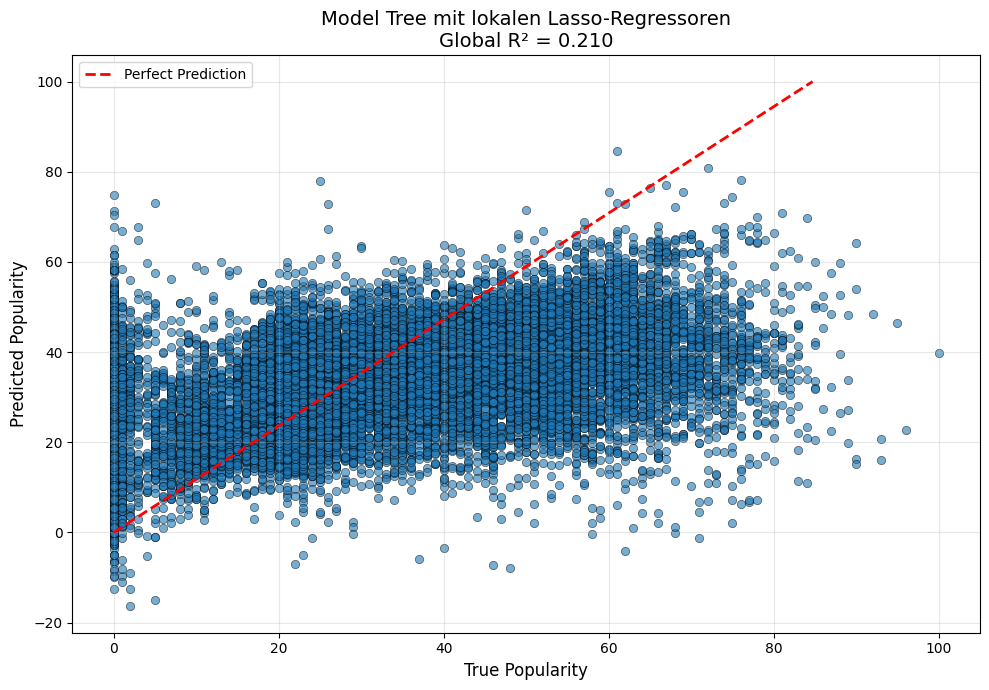

In [10]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test_arr, y_pred_mt_lasso, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test_arr.min(), y_pred_mt_lasso.max()], [y_test_arr.min(), y_test_arr.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Popularity', fontsize=12)
plt.ylabel('Predicted Popularity', fontsize=12)
plt.title(f'Model Tree mit lokalen Lasso-Regressoren\nGlobal R² = {r2:.3f}', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

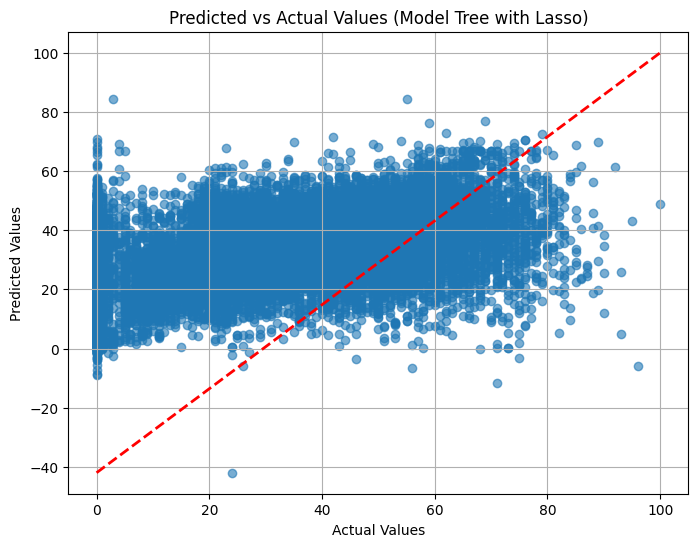

In [7]:
plt.figure(figsize=(8, 6))

# Scatter plot
plt.scatter(y_test_arr, y_pred_mt_lasso, alpha=0.6)

# Perfect prediction line
min_val = min(y_test_arr.min(), y_pred_mt_lasso.min())
max_val = max(y_test_arr.max(), y_pred_mt_lasso.max())
plt.plot([0, 100], [min_val, max_val], 'r--', lw=2)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values (Model Tree with Lasso)")
plt.grid(True)
plt.show()


In [12]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score

# 1) Base estimator (with default values; they'll be overridden by GridSearch)
mt = LassoModelTree()

# 2) Define hyperparameter grid
param_grid = {
    "max_depth": [None, 3, 5, 7, 9],
    "min_samples_leaf": [5, 10, 20, 50, 100, 200],
    # search alpha on a log scale – very common for Lasso
    "lasso_alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 1.5, 2.0]
}

# 3) Cross-validation strategy
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 4) Grid search (neg MSE because sklearn wants "higher is better")
grid = GridSearchCV(
    estimator=mt,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # or "r2"
    cv=cv,
    n_jobs=-1,     # use all cores if allowed
    verbose=1
)

# 5) Run the search
grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best CV score (neg MSE):", grid.best_score_)


Fitting 5 folds for each of 210 candidates, totalling 1050 fits


/Users/clari/datamining_group12/venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.660e-01, tolerance: 2.859e-01
  model = cd_fast.enet_coordinate_descent(
/Users/clari/datamining_group12/venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.148e-01, tolerance: 1.493e-01
  model = cd_fast.enet_coordinate_descent(
/Users/clari/datamining_group12/venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

KeyboardInterrupt: 

In [19]:
from sklearn.ensemble import BaggingRegressor

class LassoModelTree(BaseEstimator, RegressorMixin):
    """
    Model tree that:
      1. Trains a regression tree to split the feature space.
      2. In each leaf, fits a separate Lasso regression.
    """

    def __init__(self,
                 max_depth=None,
                 min_samples_leaf=20,
                 tree_random_state=42,
                 lasso_alpha=0.01,
                 lasso_max_iter=10000):
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.tree_random_state = tree_random_state
        self.lasso_alpha = lasso_alpha
        self.lasso_max_iter = lasso_max_iter

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).ravel()

        # 1) Fit a regression tree for the splits
        self.tree_ = DecisionTreeRegressor(
            criterion="squared_error",
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            random_state=self.tree_random_state,
        )
        self.tree_.fit(X, y)

        # 2) For each leaf, fit a Lasso model on the samples in that leaf
        leaf_ids = self.tree_.apply(X)
        self.leaf_models_ = {}

        for leaf in np.unique(leaf_ids):
            mask = leaf_ids == leaf
            X_leaf = X[mask]
            y_leaf = y[mask]

            model = Lasso(alpha=self.lasso_alpha, max_iter=self.lasso_max_iter)
            model.fit(X_leaf, y_leaf)
            self.leaf_models_[leaf] = model

        return self

    def predict(self, X):
        X = np.asarray(X)
        leaf_ids = self.tree_.apply(X)
        y_pred = np.empty(X.shape[0])

        for leaf in np.unique(leaf_ids):
            mask = leaf_ids == leaf
            model = self.leaf_models_[leaf]
            y_pred[mask] = model.predict(X[mask])

        return y_pred


# RANDOM FOREST OF LASSO MODEL TREES

# ensure y is 1D
y_train_arr = np.ravel(y_train)
y_test_arr = np.ravel(y_test)

# Create base Lasso Model Tree estimator
base_mt_lasso = LassoModelTree(
    max_depth=None,
    min_samples_leaf=50,
    lasso_alpha=1,
)

# Wrap in BaggingRegressor for Random Forest-style ensemble
rf_mt_lasso = BaggingRegressor(
    estimator=base_mt_lasso,
    n_estimators=50,           # number of trees in the ensemble
    random_state=42,
    n_jobs=-1,                 # use all available cores
    bootstrap=True,            # use bootstrap samples
)

# Train the ensemble
rf_mt_lasso.fit(X_train_scaled, y_train_arr)

# Make predictions
y_pred_rf_mt_lasso = rf_mt_lasso.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import mean_squared_error, r2_score


r2 = r2_score(y_test_arr, y_pred_rf_mt_lasso)
mae = mean_absolute_error(y_test, y_pred_rf_mt_lasso)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_mt_lasso))

print(f"  MAE:  {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"R^2 :  {r2:.4f}")


/Users/clari/datamining_group12/venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/clari/datamining_group12/venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/clari/datamining_group12/venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or

  MAE:  13.10
  RMSE: 17.04
R^2 :  0.3102


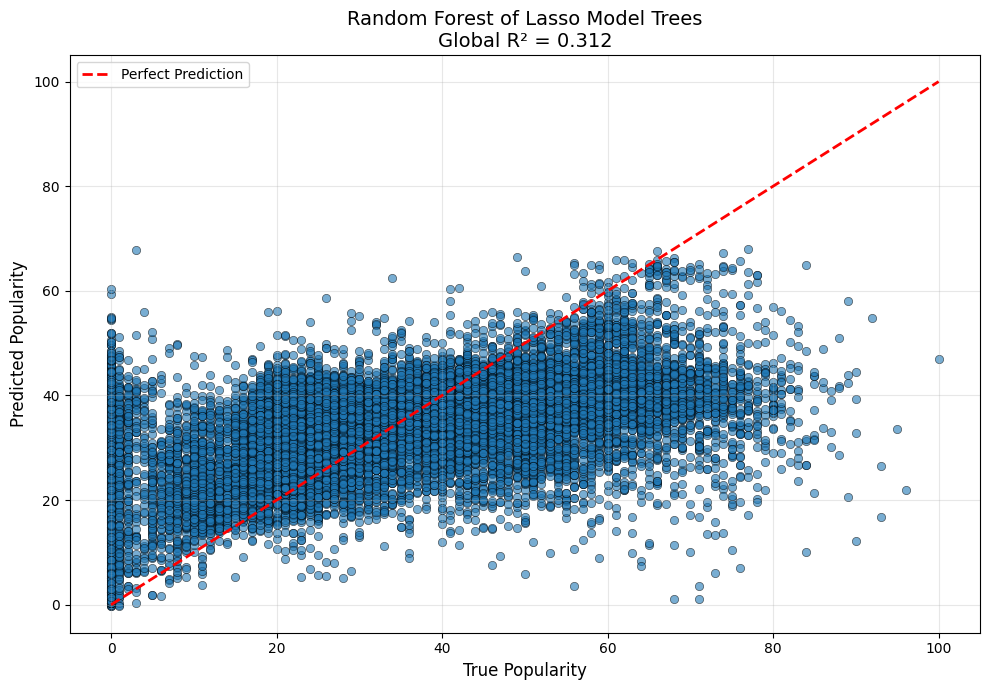

In [7]:
plt.figure(figsize=(10, 7))
plt.scatter(y_test_arr, y_pred_rf_mt_lasso, alpha=0.6, edgecolors='k', linewidth=0.5)
plt.plot([y_test_arr.min(), y_test_arr.max()], [y_test_arr.min(), y_test_arr.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('True Popularity', fontsize=12)
plt.ylabel('Predicted Popularity', fontsize=12)
plt.title(f'Random Forest of Lasso Model Trees\nGlobal R² = {r2:.3f}', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
